# Exploración de estados - Tutorial de Implementación

Este cuaderno sigue la implementación del 9-puzzle y el algorimo A* de acuerdo a las diapositivas de la asignatura de **Inteligencia Artificial**

En el 9- puzzle queremos reordenar el tablero hasta llegar a una ordenación concreta, frecuentemente el primer espacio vacío y después el resto de casillas consecutivas. 

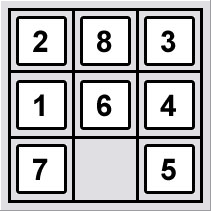

En este cuaderno se representan los estados, transiciones y la implementación de A* necesaria para resolver el problema computacionalmente.

# Implementaciones obligatorias del dominio

Primero necesitamos definir la estructura de datos que formará el estado, así como qué posibles movimientos se puede hacer sobre un estados (es decir su función de expansión)

## Estado inicial y estado meta

Para empezar usaremos la librería numpy, que facilita el uso de matrices. En esta celda vemos un ejemplo de su importación y uso.

In [1]:
import numpy as np
import random

estado_lista = list(range(9))

META = np.array(estado_lista).reshape(3,3)
random.shuffle(estado_lista)
estado_inicial = np.array(estado_lista).reshape(3,3)

print(estado_inicial)

[[0 4 1]
 [5 6 8]
 [2 7 3]]


## Expandir estados
Definimos la funcion de expansión para un estado.

Encontramos la función de utilidad mover que intercambia dos estados (suponemos que las entradas siempre son válidas)

In [2]:
direcciones = {'arriba': (-1, 0),
               'izquierda': (0, 1),
               'derecha': (0, -1),
               'abajo': (1, 0),
               }


def mover(estado, posicion, direccion):
  nuevo_estado = estado.copy()
  dir_delta = direcciones[direccion]
  p_x, p_y = posicion
  d_x, d_y = [x + y for x, y in zip(posicion, dir_delta)]
  aux = nuevo_estado[p_x, p_y]
  nuevo_estado[p_x, p_y] = nuevo_estado[d_x, d_y]
  nuevo_estado[d_x, d_y] = aux

  return nuevo_estado

def encontrar(estado, valor):
  not_found = True
  
  i = 0
  posicion = (0, 0)
  while not_found and i<3:
    j = 0
    while not_found and j<3:
      if estado[i, j] == valor:
        posicion = (i, j)
        not_found = False
      j+=1
    i+=1

  return posicion


def sucesores(estado):
  lista_expandidos = []

  # Encontrar el 0
  posicion = encontrar(estado, 0)

  # Añadir solo movimientos legales
  if posicion[0] > 0:
    nuevo = mover(estado, posicion, 'arriba')
    lista_expandidos.append(nuevo)

  if posicion[0] < 2:
    nuevo = mover(estado, posicion, 'abajo')
    lista_expandidos.append(nuevo)

  if posicion[1] > 0:
    nuevo = mover(estado, posicion, 'derecha')
    lista_expandidos.append(nuevo)

  if posicion[1] < 2:
    nuevo = mover(estado, posicion, 'izquierda')
    lista_expandidos.append(nuevo)

  return lista_expandidos

# Implementaciones opcionales del dominio

Vamos a implementar la función de coste y un heurístico que cumpla la función de minorancia.

Para darle mayor profundiad al problema, vamos a considerar que mover una pieza en el tablero cuesta tanto como el número que representa. Mover la pieza de 1, cuesta 1 y la de 8 cuesta 8.

## Función de coste

Vamos a calcularla como la diferencia entre todos los pasos del camino. Cada paso es el "abs(estado siguiente - estado anterior) / 2" de tal manera que si se ha movido la ficha 8, habrá una matriz con un (-8, 8) así computamos cada coste. 

In [3]:
def pasos(camino):
  if len(camino) == 0:
    return 0

  g = 0
  for estado_0, estado_1 in zip(camino[: -1], camino[1: ]):
    g += np.sum(abs(estado_0 - estado_1) / 2)
  return int(g)

## Función heurística
Como queremos que la heuristica calcule el coste que queda para llegar a la meta vamos a computarla como la suma de distancias manhattan entre una casilla y la solución, multiplicada por el coste de dicha casilla.

In [4]:
def distancia_manhattan(pos_1, pos_2):
  return sum(abs(x - y) for x, y in zip(pos_1, pos_2))

def heuristica(camino, estado_f):
  h = 0

  for i in range(1, 9):
    pos = encontrar(camino[0], i)
    target = encontrar(estado_f, i)
    h += distancia_manhattan(pos, target) * i

  return h

# Algoritmo de búsqueda

Programamos A* con sus funciones auxiliares, la poda y expansión.

In [5]:
def expandir(camino, sucesores):
  expansion = sucesores(camino[0])

  nuevos = []
  for n in expansion:
    if not np.any(np.all(n == camino, axis=(1, 2))):
      nuevos.append([n]+camino)

  return nuevos

def poda(caminos): # suponemos que están ordenados por coste
  res = []
  nodos = [np.zeros(shape=(3,3))] # Dummy para que no de errores
  for c in caminos:
    if not np.any(np.all(c[0] == nodos, axis=(1, 2))): # si no ha sido alcanzado
      nodos.append(c[0])

    res.append(c)
  return res

def eq(a, b):
  return np.array_equal(a,b)

# Utilidad para imprimir
def print_camino(c):
  for j, s in enumerate(c):
    if j==0:
      print(f'S{len(c)-j-1}: [g={pasos(c)}] \n{s}')
    else:
      print(f'S{len(c)-j-1}: \n{s}')

  print()


def aestrella(estado, estado_f, sucesores, g, h, terminar = eq):
  cp = [[estado]]

  j = 0
  while cp:
    if not cp: # no hay solución
      return False

    if terminar(cp[0][0], estado_f):
      # hemos encontrado una solución
      return list(reversed(cp[0]))

    print(f'-- Paso {j} -- Caminos pendientes')
    for i, c in enumerate(cp):
      print(f'CP[{i}]: ')
      print_camino(c)

    
    expansion = expandir(cp[0], sucesores)
    print(f'-- Paso {j} -- Expandidos')
    for i, c in enumerate(expansion):
      print(f'E[{i}]: ')
      print_camino(c)

    unsrt = cp[1:] + expansion
    unsrt.sort(key=lambda x: g(x)+h(x, estado_f))
    cp = poda(unsrt)

    j+=1
  
  return "No se ha encontrado camino"

# Ejecución

Aquí lanzamos A*
Declaramos un estado final que no sea demasiado difícil para no tardar mucho en ejecutarlo. ¡Vamos a probarlo!

In [6]:
estado_inicial = np.array([1, 2, 5, 0, 4, 8, 3, 6, 7]).reshape(3, 3)

c_final = aestrella(estado_inicial, META, sucesores, pasos, heuristica, terminar = eq)

print_camino(c_final)

-- Paso 0 -- Caminos pendientes
CP[0]: 
S0: [g=0] 
[[1 2 5]
 [0 4 8]
 [3 6 7]]

-- Paso 0 -- Expandidos
E[0]: 
S1: [g=1] 
[[0 2 5]
 [1 4 8]
 [3 6 7]]
S0: 
[[1 2 5]
 [0 4 8]
 [3 6 7]]

E[1]: 
S1: [g=3] 
[[1 2 5]
 [3 4 8]
 [0 6 7]]
S0: 
[[1 2 5]
 [0 4 8]
 [3 6 7]]

E[2]: 
S1: [g=4] 
[[1 2 5]
 [4 0 8]
 [3 6 7]]
S0: 
[[1 2 5]
 [0 4 8]
 [3 6 7]]

-- Paso 1 -- Caminos pendientes
CP[0]: 
S1: [g=3] 
[[1 2 5]
 [3 4 8]
 [0 6 7]]
S0: 
[[1 2 5]
 [0 4 8]
 [3 6 7]]

CP[1]: 
S1: [g=1] 
[[0 2 5]
 [1 4 8]
 [3 6 7]]
S0: 
[[1 2 5]
 [0 4 8]
 [3 6 7]]

CP[2]: 
S1: [g=4] 
[[1 2 5]
 [4 0 8]
 [3 6 7]]
S0: 
[[1 2 5]
 [0 4 8]
 [3 6 7]]

-- Paso 1 -- Expandidos
E[0]: 
S2: [g=9] 
[[1 2 5]
 [3 4 8]
 [6 0 7]]
S1: 
[[1 2 5]
 [3 4 8]
 [0 6 7]]
S0: 
[[1 2 5]
 [0 4 8]
 [3 6 7]]

-- Paso 2 -- Caminos pendientes
CP[0]: 
S2: [g=9] 
[[1 2 5]
 [3 4 8]
 [6 0 7]]
S1: 
[[1 2 5]
 [3 4 8]
 [0 6 7]]
S0: 
[[1 2 5]
 [0 4 8]
 [3 6 7]]

CP[1]: 
S1: [g=1] 
[[0 2 5]
 [1 4 8]
 [3 6 7]]
S0: 
[[1 2 5]
 [0 4 8]
 [3 6 7]]

CP[2]: 
S1: [g=4]

Una buena heurística acorta el tiempo de ejecución. Cambiamos la heurística para que sea algo peor. Vemos como pasa de dar 6 pasos a dar 86.

In [7]:
def heuristica(camino, estado_f):
  h = 0

  for i in range(1, 9):
    pos = encontrar(camino[0], i)
    target = encontrar(estado_f, i)
    h += distancia_manhattan(pos, target)

  return h

c_final = aestrella(estado_inicial, META, sucesores, pasos, heuristica, terminar = eq)

print_camino(c_final)

Streaming output truncated to the last 5000 lines.
[[1 2 5]
 [0 4 8]
 [3 6 7]]

CP[3]: 
S7: [g=25] 
[[3 1 5]
 [6 2 8]
 [0 4 7]]
S6: 
[[3 1 5]
 [0 2 8]
 [6 4 7]]
S5: 
[[0 1 5]
 [3 2 8]
 [6 4 7]]
S4: 
[[1 0 5]
 [3 2 8]
 [6 4 7]]
S3: 
[[1 2 5]
 [3 0 8]
 [6 4 7]]
S2: 
[[1 2 5]
 [3 4 8]
 [6 0 7]]
S1: 
[[1 2 5]
 [3 4 8]
 [0 6 7]]
S0: 
[[1 2 5]
 [0 4 8]
 [3 6 7]]

CP[4]: 
S7: [g=27] 
[[4 1 5]
 [3 2 8]
 [6 7 0]]
S6: 
[[4 1 5]
 [3 2 8]
 [6 0 7]]
S5: 
[[4 1 5]
 [3 2 8]
 [0 6 7]]
S4: 
[[4 1 5]
 [0 2 8]
 [3 6 7]]
S3: 
[[0 1 5]
 [4 2 8]
 [3 6 7]]
S2: 
[[1 0 5]
 [4 2 8]
 [3 6 7]]
S1: 
[[1 2 5]
 [4 0 8]
 [3 6 7]]
S0: 
[[1 2 5]
 [0 4 8]
 [3 6 7]]

CP[5]: 
S5: [g=23] 
[[1 2 5]
 [6 0 8]
 [4 3 7]]
S4: 
[[1 2 5]
 [0 6 8]
 [4 3 7]]
S3: 
[[1 2 5]
 [4 6 8]
 [0 3 7]]
S2: 
[[1 2 5]
 [4 6 8]
 [3 0 7]]
S1: 
[[1 2 5]
 [4 0 8]
 [3 6 7]]
S0: 
[[1 2 5]
 [0 4 8]
 [3 6 7]]

CP[6]: 
S10: [g=26] 
[[4 1 5]
 [3 2 8]
 [6 0 7]]
S9: 
[[4 1 5]
 [3 2 8]
 [0 6 7]]
S8: 
[[4 1 5]
 [0 2 8]
 [3 6 7]]
S7: 
[[4 1 5]
 [2 0 8]
 [3 6 7]

# Ejercicios

## Ejercicio 1
  Implementa el algoritmo de escalada. Usa las funciones dadas, sin tocar nada más.

In [ ]:
##
## IMPLEMENTACION ESCALADA
##

In [ ]:
estado_inicial = np.array([1, 2, 5, 0, 4, 8, 3, 6, 7]).reshape(3, 3)
c_final = escalada(estado_inicial, META, sucesores, pasos, heuristica, terminar = eq)
print_camino(c_final)

## Ejercicio 2
Implementa una estrategia de búsqueda nueva, en la que cada vez se explora un elemento de CP al azar.

In [ ]:
##
## IMPLEMENTACION RANDOM WALK
##

In [ ]:
estado_inicial = np.array([1, 2, 0, 3, 4, 5, 6, 7, 8]).reshape(3, 3)
c_final = randomwalk(estado_inicial, META, sucesores, pasos, heuristica, terminar = eq)
print_camino(c_final)

## Ejercicio 3
Ahora cambia el dominio del problema. Queremos aplicar los métodos anteriores sobre el problema de las Torres de Hanoi de altura 8.



1.   Declara el estado meta nuevo
2.   Declara el estado inicial nuevo
3.   Implementa la nueva función de sucesores
4.   Implementa g y h adecuadas, con h cumplinedo la condicion de minorancia
5.   Lanza los tres algoritmos de búsqueda (A*, Escalada y Random Walk)



In [ ]:
##
## Inserta el nuevo código aquí
##

estado_inicial_hanoi = None # Declara esto
meta_hanoi = None # y esto otro

In [ ]:
c_final = aestrella(estado_inicial_hanoi, meta_hanoi, sucesores_hanoi, len, heuristica_hanoi, terminar = eq)
print_camino(c_final)

In [ ]:
c_final = escalada(estado_inicial_hanoi, meta_hanoi, sucesores_hanoi, len, heuristica_hanoi, terminar = eq)
print_camino(c_final)

In [ ]:
c_final = randomwalk(estado_inicial_hanoi, meta_hanoi, sucesores_hanoi, len, heuristica_hanoi, terminar = eq)
print_camino(c_final)

## Ejercicio 4

Una optimización de A* es explorar desde ambos extremos, la meta y el estado inicial. Esto se conoce como A* Bidireccional. Para ello es necesario:


1.   Implementar una función de sucesores a la inversa, de un destino extraer el estado anterior.
2.   Mantener dos listas de caminos pendientes, iterando sucesivamente.
3.   Una heuristica y un coste para llegar de la meta al estado inicial.

In [ ]:
##
## A*BIDIRECCIONAL
##

In [ ]:
c_final = None # Incluye tu propio código, puedes alterar las entradas esta vez.
print_camino(c_final)